### ASTROINFORMATICS
https://github.com/astromundus/ns_dec2018


# Parametric Clustering with GMM

##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 6.  
 
- code taken and modified from astroML 

##### Fix to figure 4.2 from the [Textbook](http://press.princeton.edu/titles/10159.html), based on 1-D GMM code from 
http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html#book-fig-chapter4-fig-gmm-1d
 

In [1]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize = 8, usetex = True)
np.random.seed(1)

In [2]:
# setup data
X = np.hstack([np.random.normal(-2, 1.5, 300), 
	np.random.normal(0, 1, 500),
	np.random.normal(3, 0.5, 200)])
X = np.reshape(X, [1000, 1])

## Learn the best-fit GMM models
#  Here we'll use GMM in the standard way: the fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

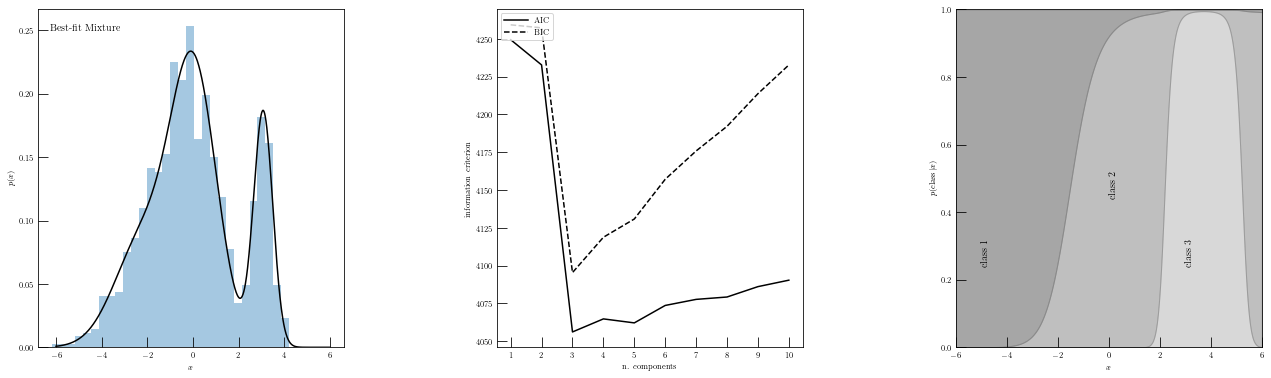

In [3]:
#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize = (20, 6.8))
fig.subplots_adjust(left = 0.12, right = 0.97, bottom = 0.21, top = 0.9, wspace = 0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
ax.xaxis.set_ticks(np.arange(-6, 8, 2))
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10)

x = np.linspace(-6, 6, 1000)
x = x.reshape([1000, 1])
#logprob, responsibilities = M_best.eval(x)
M_best = models[np.argmin(AIC)]
logprob = M_best.score_samples(x)
pdf = np.exp(logprob)
#pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density = True, histtype = 'stepfilled', alpha = 0.4)
ax.plot(x, pdf, '-k')
#ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture", ha = 'left', va = 'top', transform = ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10)
ax.xaxis.set_ticks(np.arange(1, 11, 1))
ax.plot(N, AIC, '-k', label = 'AIC')
ax.plot(N, BIC, '--k', label = 'BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc = 2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)
ax.xaxis.set_ticks(np.arange(-6, 8, 2))
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10)

p = M_best.predict_proba(x)
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

x = x.reshape([1000])
ax.fill_between(x, 0, p[0], color = 'gray', alpha = 0.3)
ax.fill_between(x, p[0], p[1], color = 'gray', alpha = 0.5)
ax.fill_between(x, p[1], 1, color = 'gray', alpha = 0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation = 'vertical')
ax.text(0, 0.5, 'class 2', rotation = 'vertical')
ax.text(3, 0.3, 'class 3', rotation = 'vertical')

plt.show()

![Parker et al. asteroid families](http://www.astro.washington.edu/users/ivezic/sdssmoc/MOC4_population_labels.jpg) 

In [4]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.datasets import fetch_moving_objects
from astroML.plotting.tools import draw_ellipse
from astroML.clustering import HierarchicalClustering, get_graph_segments
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

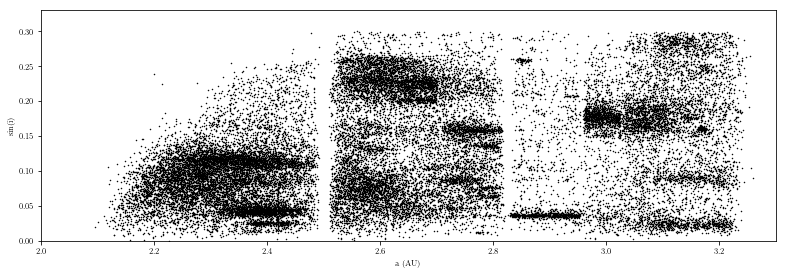

In [5]:
# Fetch data and extract the desired quantities
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
# matrix X is our "main data carrier"
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [6]:
#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 60)
def compute_GMM(N, dataMatrix, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i], max_iter=max_iter,
                        covariance_type=covariance_type)
        models[i].fit(dataMatrix)
    return models

models = compute_GMM(N, X)
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  44


0 9 0.0397087073004
1 17 0.0376466305737
2 26 0.0364816128409
3 5 0.0356602802871
4 2 0.0340812889233
5 38 0.0327287982537
6 28 0.0319447136361
7 1 0.0298512092793
8 0 0.0296831041772
9 14 0.0291119796107
10 8 0.0290209543503
11 34 0.0286569038991
12 33 0.028385443007
13 19 0.0273649715992
14 43 0.0259618126629
15 3 0.0257266250046
16 18 0.025456178954
17 24 0.0247697405433
18 31 0.0246824381919
19 21 0.0244556972176
20 42 0.0230753616116
21 36 0.0224400234808
22 4 0.0214241847349
23 25 0.0212771053236
24 22 0.0202618271717
25 40 0.0195051314249
26 39 0.0187648957293
27 6 0.0186954022225
28 37 0.0181491996778
29 30 0.0178283780468
30 35 0.0176121999065
31 15 0.0170242686062
32 13 0.0168304167976
33 16 0.0162825170464
34 23 0.0162767698515
35 27 0.0160371230823
36 29 0.0154164094666
37 7 0.0141601271753
38 10 0.0139602245736
39 41 0.0139600495394
40 32 0.0130235178183
41 11 0.0124634457352
42 12 0.0107389827905
43 20 0.0034133478741


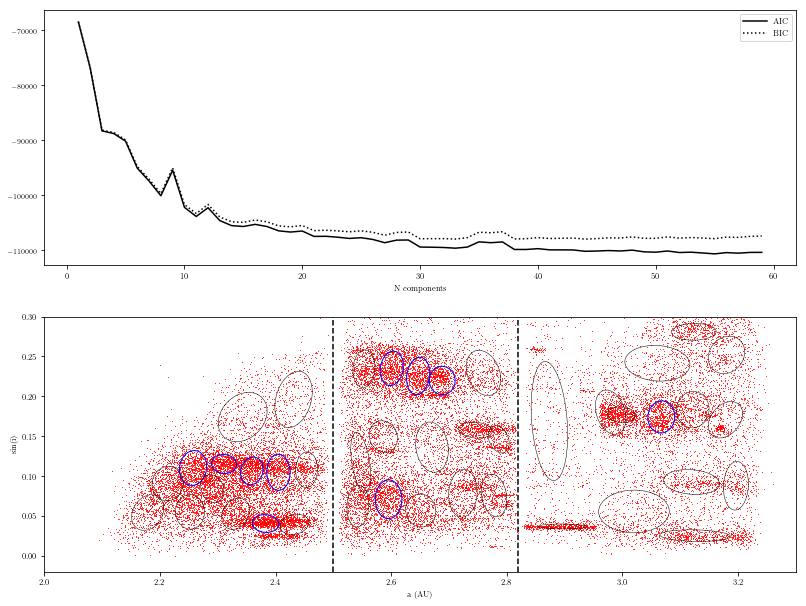

In [7]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(211)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(212)

ax.scatter(a, sini, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    if (cnt<10):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')
 
ax.plot([2.5, 2.5], [-0.02, 0.3], '--k')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--k')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()